In [1]:
import pandas as pd 
import os
import numpy as np 

In [2]:
main_path='/home/rajesh/work/ketosis_project/files'


In [3]:
sensor_values = [
    file for file in os.listdir('/home/rajesh/work/ketosis_project/files')
    if file.startswith(('1', '2'))
]

In [4]:
sensor_values

['2_20_2025.csv',
 '2_7_2025.csv',
 '2_14_2025.csv',
 '1_3_2025.csv',
 '1_31_2025.csv']

In [5]:
list_df=[]
for path in sensor_values:
    temp=pd.read_csv(os.path.join(main_path, path))
    temp['date']=  path.split('.')[0]
    temp['date']= pd.to_datetime(temp['date'], format="%m_%d_%Y")
    list_df.append(temp)
sensor_df= pd.concat(list_df)

In [6]:
cohort1_dates = pd.to_datetime([
    '01-03-2025', '01-11-2025', '01-17-2025',
     '12-20-2024','12-27-2024' 
], format='%m-%d-%Y')

# Assign cohort
sensor_df['cohort'] = sensor_df['date'].apply(
    lambda x: 1 if x in cohort1_dates else 2
)
dict_dates_cohort_1= {value: i for i, value in enumerate(cohort1_dates)}

sensor_df['day'] = np.where(
    sensor_df['cohort'] == 1,
    sensor_df['date'].map(dict_dates_cohort_1),
    np.nan
)

sensor_df['date'] = np.where(sensor_df['date'] == pd.Timestamp('2025-02-20'),
                             pd.Timestamp('2025-02-21'),
                             sensor_df['date'])

cohort2_dates= pd.to_datetime([
'2025-01-24',
 '2025-01-31', '2025-02-07', '2025-02-14',
 '2025-02-21'
], format='%Y-%m-%d')

dict_dates_cohort_2= { value:i for i, value in enumerate(cohort2_dates)}

sensor_df['day']= np.where(

    sensor_df['cohort']==2,
    sensor_df['date'].map(dict_dates_cohort_2),
    np.nan
)

### extracting the serum work

In [7]:
serum_report=pd.read_csv('/home/rajesh/work/ketosis_project/files/serum_report.csv')

In [8]:
serum_report['date']= pd.to_datetime(serum_report['DATE'])

In [9]:
sensor_df['sensor_values'] = sensor_df['sensor_values'].fillna(sensor_df['sensor values'])


In [10]:
sensor_df['date']= pd.to_datetime(sensor_df['date'])

In [11]:
merged_df = sensor_df.merge(
    serum_report,
    left_on=['date', 'cowid'],
    right_on=['date', 'COWID'],
    how='inner'
)


In [12]:
milk_df= pd.read_csv(os.path.join(main_path, 'DHI MILK(Sheet1).csv'))

In [13]:
milk_df.columns

Index(['DATE', 'COHORT', 'PEN', 'TREATMENT', 'COWID', 'DAY', 'Fat', 'Protein',
       'Lactose', 'SNF', 'MUN', 'SCC', 'BHB', 'Acetone', 'Unnamed: 14',
       'Unnamed: 15', 'sick ', 'Check', 'no data '],
      dtype='object')

In [14]:
milk_df['date']= pd.to_datetime(milk_df['DATE'])

In [15]:
milk_df['cowid'] = milk_df['COWID'].astype(str).str.split(' ').str[0].astype('int64')


In [16]:
merged_milk_df= merged_df.merge(
    milk_df,
    left_on=['date', 'cowid'],
    right_on=['date', 'cowid'],
    how='inner'

)

In [17]:
merged_milk_df['blood'].isna().sum()

np.int64(98)

In [18]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
merged_milk_df['sensor_values_scaled']= merged_milk_df.groupby('date')['sensor_values'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1,1)).flatten())

In [19]:
merged_milk_df['BHB_scaled']= merged_milk_df.groupby('date')['BHB'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1,1)).flatten())

In [20]:
merged_milk_df['Acetone_scaled']= merged_milk_df.groupby('date')['Acetone'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1,1)).flatten())

In [21]:
merged_milk_df[['blood', 'sensor_values']].corr()

,blood,sensor_values
blood,1.000000,0.248076
sensor_values,0.248076,1.000000


In [22]:
merged_milk_df.cowid.nunique()

57

In [23]:
merged_milk_df['hbut']= merged_milk_df['HBUT (mg/dL)'].astype(float)

In [24]:
merged_milk_df.describe()[['sensor_values', 'TBIL (mg/dL)', 'NEFA (meEq/L)',
       'GLUC (mg/dL)', 'CHOL (mg/dL)', 'AST (U/L)', 'ALB (TL=<0.5) *(g/dL)','hbut',
       'COHORT_y', 'PEN_y', 'DAY_y', 'Fat', 'Protein', 'Lactose', 'SNF', 'MUN',
       'SCC', 'BHB', 'Acetone', 'blood']].T[['mean', 'min', '25%', '50%', '75%', 'max', 'std']].round(2)

,mean,min,25%,50%,75%,max,std
sensor_values,3.25,0.01,0.36,1.91,4.28,14.25,3.70
TBIL (mg/dL),0.06,0.00,0.00,0.00,0.10,0.20,0.07
NEFA (meEq/L),0.14,0.02,0.08,0.12,0.19,0.37,0.08
GLUC (mg/dL),36.75,9.00,27.00,35.00,48.50,76.00,13.20
CHOL (mg/dL),178.51,27.00,112.00,148.00,247.50,423.00,92.87
AST (U/L),49.76,6.00,29.50,45.00,65.00,301.00,34.05
ALB (TL=<0.5) *(g/dL),2.22,0.50,1.50,1.90,3.20,3.90,0.98
hbut,4.96,1.70,3.15,4.80,6.10,15.40,2.33
COHORT_y,1.74,1.00,1.00,2.00,2.00,2.00,0.44
PEN_y,5.13,2.00,5.00,5.00,6.00,6.00,0.98


In [25]:
merged_milk_df['Breath Acetone (ppm)']= merged_milk_df['sensor_values']
merged_milk_df['Serum BHB (mmol/L)']= merged_milk_df['hbut'] * 0.0961
merged_milk_df['Milk Acetone (mM/L)']= merged_milk_df['Acetone']
merged_milk_df['Milk BHB (mM/L)']= merged_milk_df['BHB']
merged_milk_df['Serum NEFA (meEq/L)']= merged_milk_df['NEFA (meEq/L)']
merged_milk_df['Serum GLUC (mg/dL)']= merged_milk_df['GLUC (mg/dL)']

In [26]:
merged_milk_df.columns

Index(['cowid', 'sensor_values', 'blood', 'date', 'sensor values', 'cohort',
       'day', 'DATE_x', 'COHORT_x', 'PEN_x', 'TREATMENT_x', 'COWID_x', 'DAY_x',
       'DIM', 'LACT', 'TBIL (mg/dL)', 'NEFA (meEq/L)', 'HBUT (mg/dL)',
       'GLUC (mg/dL)', 'GGT (U/L)', 'CHOL (mg/dL)', 'AST (U/L)', 'ALT (U/L)',
       'ALP (U/L)', 'ALB (TL=<0.5) *(g/dL)', 'DATE_y', 'COHORT_y', 'PEN_y',
       'TREATMENT_y', 'COWID_y', 'DAY_y', 'Fat', 'Protein', 'Lactose', 'SNF',
       'MUN', 'SCC', 'BHB', 'Acetone', 'Unnamed: 14', 'Unnamed: 15', 'sick ',
       'Check', 'no data ', 'sensor_values_scaled', 'BHB_scaled',
       'Acetone_scaled', 'hbut', 'Breath Acetone (ppm)', 'Serum BHB (mmol/L)',
       'Milk Acetone (mM/L)', 'Milk BHB (mM/L)', 'Serum NEFA (meEq/L)',
       'Serum GLUC (mg/dL)'],
      dtype='object')

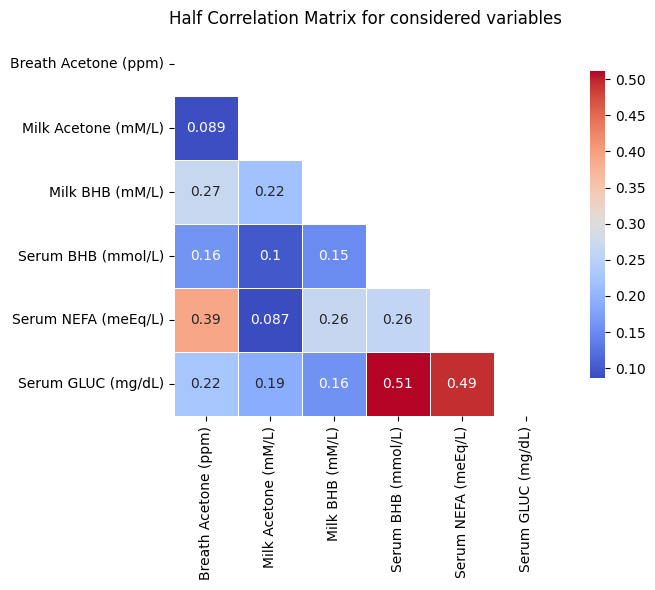

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
matrix=merged_milk_df[[  'Breath Acetone (ppm)', 'Milk Acetone (mM/L)',
       'Milk BHB (mM/L)', 'Serum BHB (mmol/L)', 'Serum NEFA (meEq/L)',
       'Serum GLUC (mg/dL)'
]].corr()
mask = np.triu(np.ones_like(matrix, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, mask=mask, annot=True, cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Half Correlation Matrix for considered variables')
plt.tight_layout()
plt.show()

In [55]:
merged_milk_df.to_csv('/home/rajesh/work/ketosis_project/files/processed_files/merged_milk_df.csv')

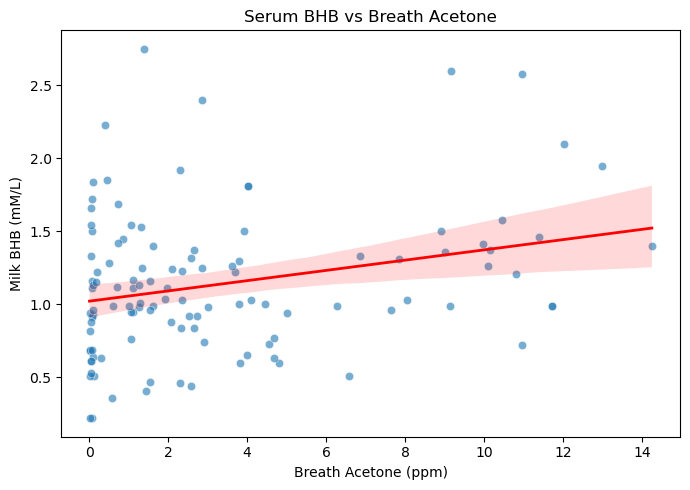

NameError: name 'r' is not defined

In [ ]:
# ...existing code...
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr


# plot scatter + fitted line (regression) and annotate r^2
plt.figure(figsize=(7,5))
ax = sns.scatterplot(x='Breath Acetone (ppm)', y='Milk BHB (mM/L)', data=merged_milk_df, alpha=0.6)
sns.regplot(x='Breath Acetone (ppm)', y='Milk BHB (mM/L)', data= merged_milk_df, scatter=False, ax=ax, color='red', line_kws={'lw':2})


ax.set_title('Serum BHB vs Breath Acetone')
ax.set_xlabel('Breath Acetone (ppm)')
ax.set_ylabel('Milk BHB (mM/L)')
plt.tight_layout()
plt.show()

# print numeric summary

# ...existing code...

In [ ]:
# ...existing code...
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

# prepare data

plt.figure(figsize=(7,5))
ax = sns.scatterplot(x='Breath Acetone (ppm)', y='Serum BHB (mmol/L)', data=df, alpha=0.6)
sns.regplot(x='Breath Acetone (ppm)', y='Serum BHB (mmol/L)', data=df, scatter=False, ax=ax, color='red', line_kws={'lw':2})


ax.set_title('Serum BHB vs Breath Acetone')
ax.set_xlabel('Breath Acetone (ppm)')
ax.set_ylabel('Serum BHB (mmol/L)')
plt.tight_layout()
plt.show()

# print numeric summary
print(f"Pearson r: {r:.4f}, R²: {r2:.4f}, p-value: {p:.4e}")
# ...existing code...

In [33]:
import statsmodels.formula.api as smf

# Mixed effects model
# Assuming 'BHB' is the outcome and 'sensor_values' is predictor
model = smf.mixedlm("hbut ~ sensor_values",
                    merged_milk_df,
                    groups=merged_milk_df["cowid"])
result = model.fit()

print(result.summary())


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: hbut     
No. Observations: 115     Method:             REML     
No. Groups:       57      Scale:              5.0708   
Min. group size:  1       Log-Likelihood:     -260.8853
Max. group size:  5       Converged:          Yes      
Mean group size:  2.0                                  
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     4.643    0.293 15.818 0.000  4.067  5.218
sensor_values 0.099    0.058  1.691 0.091 -0.016  0.213
Group Var     0.268    0.252                           



In [34]:
import numpy as np

# Fit model
model = smf.mixedlm("hbut ~ sensor_values",
                    merged_milk_df,
                    groups=merged_milk_df["cowid"])
result = model.fit()

# Predicted values
merged_milk_df["fitted"] = result.fittedvalues

# Residuals
merged_milk_df["resid"] = merged_milk_df["BHB"] - merged_milk_df["fitted"]

# Pseudo R-squared
r2 = np.corrcoef(merged_milk_df["BHB"], merged_milk_df["fitted"])[0,1]**2

print("Pseudo R²:", r2)
print(result.summary())



Pseudo R²: 0.12543207848463506
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: hbut     
No. Observations: 115     Method:             REML     
No. Groups:       57      Scale:              5.0708   
Min. group size:  1       Log-Likelihood:     -260.8853
Max. group size:  5       Converged:          Yes      
Mean group size:  2.0                                  
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     4.643    0.293 15.818 0.000  4.067  5.218
sensor_values 0.099    0.058  1.691 0.091 -0.016  0.213
Group Var     0.268    0.252                           



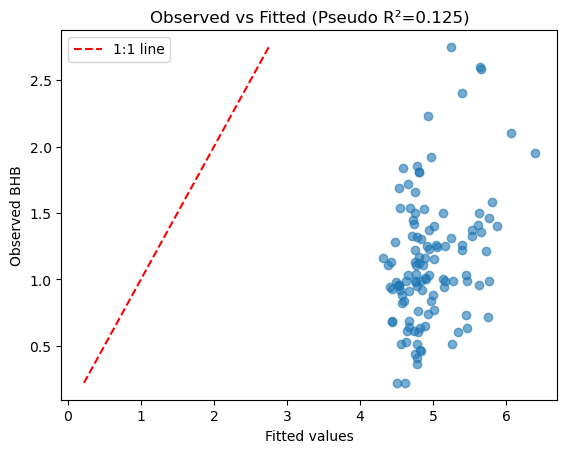

In [55]:
import matplotlib.pyplot as plt

plt.scatter(merged_milk_df["fitted"], merged_milk_df["BHB"], alpha=0.6)
plt.plot([merged_milk_df["BHB"].min(), merged_milk_df["BHB"].max()],
         [merged_milk_df["BHB"].min(), merged_milk_df["BHB"].max()],
         'r--', label="1:1 line")
plt.xlabel("Fitted values")
plt.ylabel("Observed BHB")
plt.legend()
plt.title(f"Observed vs Fitted (Pseudo R²={r2:.3f})")
plt.show()


In [35]:
# Mixed effects model for Acetone
model_acetone = smf.mixedlm("Acetone ~ sensor_values",
                            merged_milk_df,
                            groups=merged_milk_df["cowid"])
result_acetone = model_acetone.fit()

# Predicted values
merged_milk_df["fitted_acetone"] = result_acetone.fittedvalues

# Residuals
merged_milk_df["resid_acetone"] = merged_milk_df["Acetone"] - merged_milk_df["fitted_acetone"]

# Pseudo R-squared
r2_acetone = np.corrcoef(merged_milk_df["Acetone"], merged_milk_df["fitted_acetone"])[0,1]**2

print("Pseudo R² (Acetone):", r2_acetone)
print(result_acetone.summary())


Pseudo R² (Acetone): 0.6606995614694094
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Acetone 
No. Observations: 115     Method:             REML    
No. Groups:       57      Scale:              0.0008  
Min. group size:  1       Log-Likelihood:     211.5783
Max. group size:  5       Converged:          Yes     
Mean group size:  2.0                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.027    0.005 5.228 0.000  0.017  0.036
sensor_values 0.000    0.001 0.337 0.736 -0.001  0.002
Group Var     0.001    0.008                          



/usr/lib/python3/dist-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


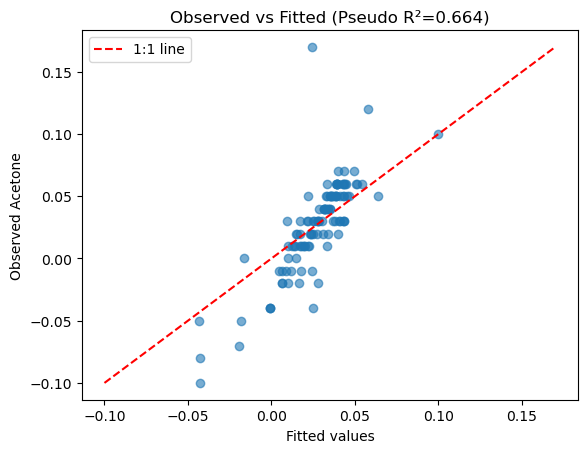

In [33]:
plt.scatter(merged_milk_df["fitted_acetone"], merged_milk_df["Acetone"], alpha=0.6)
plt.plot([merged_milk_df["Acetone"].min(), merged_milk_df["Acetone"].max()],
         [merged_milk_df["Acetone"].min(), merged_milk_df["Acetone"].max()],
         'r--', label="1:1 line")
plt.xlabel("Fitted values")
plt.ylabel("Observed Acetone")
plt.legend()
plt.title(f"Observed vs Fitted (Pseudo R²={r2_acetone:.3f})")
plt.show()


In [36]:
merged_milk_df['nefa']=merged_milk_df['NEFA (meEq/L)'] 

In [37]:
# Mixed effects model for NEFA
model_nefa = smf.mixedlm("nefa ~ sensor_values",
                         merged_milk_df,
                         groups=merged_milk_df["cowid"])
result_nefa = model_nefa.fit()

# Predicted values
merged_milk_df["fitted_nefa"] = result_nefa.fittedvalues

# Residuals
merged_milk_df["resid_nefa"] = merged_milk_df["nefa"] - merged_milk_df["fitted_nefa"]

# Pseudo R-squared
r2_nefa = np.corrcoef(merged_milk_df["nefa"], merged_milk_df["fitted_nefa"])[0,1]**2

print("Pseudo R² (NEFA):", r2_nefa)
print(result_nefa.summary())


Pseudo R² (NEFA): 0.2772422470646949
         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: nefa    
No. Observations:  115     Method:             REML    
No. Groups:        57      Scale:              0.0051  
Min. group size:   1       Log-Likelihood:     128.0176
Max. group size:   5       Converged:          Yes     
Mean group size:   2.0                                 
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.106    0.010 10.863 0.000  0.087  0.125
sensor_values 0.009    0.002  4.634 0.000  0.005  0.012
Group Var     0.000    0.008                           



/usr/lib/python3/dist-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


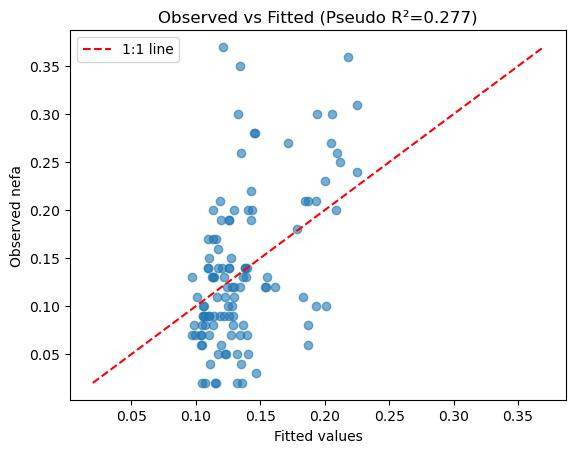

In [38]:
plt.scatter(merged_milk_df["fitted_nefa"], merged_milk_df["nefa"], alpha=0.6)
plt.plot([merged_milk_df["nefa"].min(), merged_milk_df["nefa"].max()],
         [merged_milk_df["nefa"].min(), merged_milk_df["nefa"].max()],
         'r--', label="1:1 line")
plt.xlabel("Fitted values")
plt.ylabel("Observed nefa")
plt.legend()
plt.title(f"Observed vs Fitted (Pseudo R²={r2_nefa:.3f})")
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


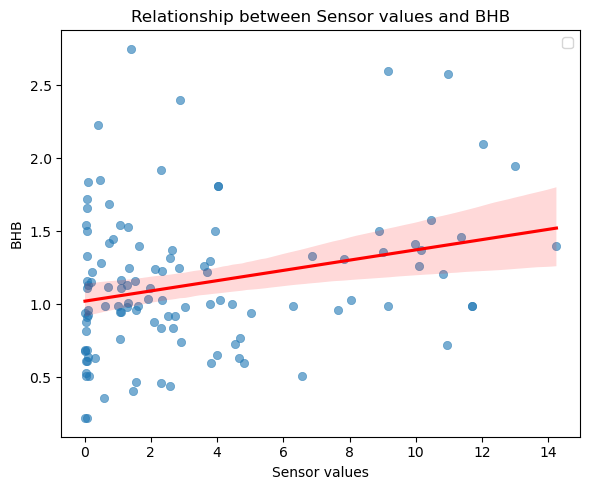

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fit mixed model
model = smf.mixedlm("BHB ~ sensor_values", merged_milk_df, groups=merged_milk_df["cowid"])
result = model.fit()

# Extract p-value for sensor_values
pval = result.pvalues["sensor_values"]

# Scatter plot + regression line
plt.figure(figsize=(6,5))
sns.scatterplot(x="sensor_values", y="BHB", data=merged_milk_df, alpha=0.6, edgecolor=None)
sns.regplot(x="sensor_values", y="BHB", data=merged_milk_df,
            scatter=False, color="red", line_kws={"label":f"p = {pval:.3e}"})

# Labels and title
plt.xlabel("Sensor values")
plt.ylabel("BHB")
plt.legend()
plt.title("Relationship between Sensor values and BHB")
plt.tight_layout()
plt.show()


In [40]:
result.pvalues["sensor_values"]

0.02268452858409708

In [41]:
from scipy.stats import zscore

# Compute z-scores for sensor_values
merged_milk_df["sensor_z"] = zscore(merged_milk_df["sensor_values"], nan_policy='omit')

# Filter out rows with |z| > 3 (common cutoff, you can adjust)
filtered_df = merged_milk_df[merged_milk_df["sensor_z"].abs() <= 3].copy()

print("Original size:", merged_milk_df.shape[0])
print("Filtered size:", filtered_df.shape[0])

# Fit mixed model on filtered data
model = smf.mixedlm("BHB ~ sensor_values",
                    filtered_df,
                    groups=filtered_df["cowid"])
result = model.fit()

print(result.summary())


Original size: 115
Filtered size: 115
         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: BHB     
No. Observations:  115     Method:             REML    
No. Groups:        57      Scale:              0.1008  
Min. group size:   1       Log-Likelihood:     -68.8100
Max. group size:   5       Converged:          Yes     
Mean group size:   2.0                                 
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     1.026    0.064 16.047 0.000  0.900  1.151
sensor_values 0.022    0.010  2.279 0.023  0.003  0.041
Group Var     0.119    0.140                           



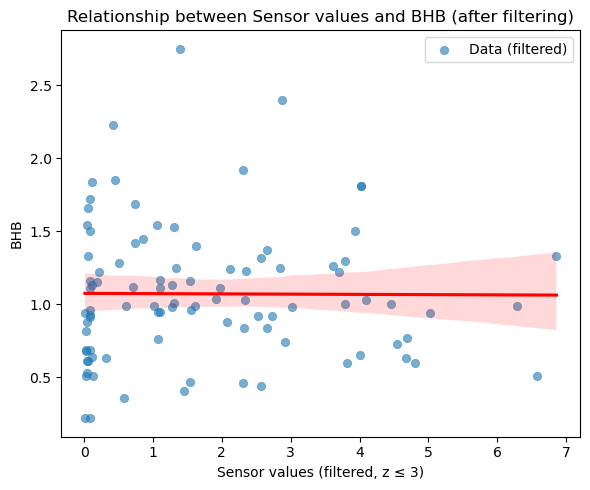

In [42]:
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt

# --- Z-score filtering ---
merged_milk_df["sensor_z"] = zscore(merged_milk_df["sensor_values"], nan_policy='omit')
filtered_df = merged_milk_df[merged_milk_df["sensor_z"].abs() <= 1].copy()

# --- Mixed model fit ---
model = smf.mixedlm("BHB ~ sensor_values",
                    filtered_df,
                    groups=filtered_df["cowid"])
result = model.fit()

# Extract p-value for fixed effect
pval = result.pvalues["sensor_values"]

# --- Plot ---
plt.figure(figsize=(6,5))
sns.scatterplot(x="sensor_values", y="BHB", data=filtered_df,
                alpha=0.6, edgecolor=None, label="Data (filtered)")
sns.regplot(x="sensor_values", y="BHB", data=filtered_df,
            scatter=False, color="red",
            line_kws={"label": f"p = {pval:.3e}"})

plt.xlabel("Sensor values (filtered, z ≤ 3)")
plt.ylabel("BHB")
plt.title("Relationship between Sensor values and BHB (after filtering)")
plt.legend()
plt.tight_layout()
plt.show()


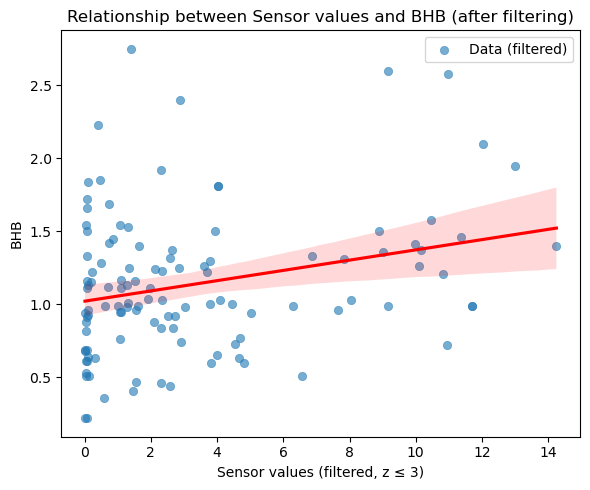

In [43]:
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt

# --- Z-score filtering ---
merged_milk_df["sensor_z"] = zscore(merged_milk_df["sensor_values"], nan_policy='omit')
filtered_df = merged_milk_df[merged_milk_df["sensor_z"].abs() <= 3].copy()

# --- Mixed model fit ---
model = smf.mixedlm("BHB ~ sensor_values",
                    filtered_df,
                    groups=filtered_df["cowid"])
result = model.fit()

# Extract p-value for fixed effect
pval = result.pvalues["sensor_values"]

# --- Plot ---
plt.figure(figsize=(6,5))
sns.scatterplot(x="sensor_values", y="BHB", data=filtered_df,
                alpha=0.6, edgecolor=None, label="Data (filtered)")
sns.regplot(x="sensor_values", y="BHB", data=filtered_df,
            scatter=False, color="red",
            line_kws={"label": f"p = {pval:.3e}"})

plt.xlabel("Sensor values (filtered, z ≤ 3)")
plt.ylabel("BHB")
plt.title("Relationship between Sensor values and BHB (after filtering)")
plt.legend()
plt.tight_layout()
plt.show()


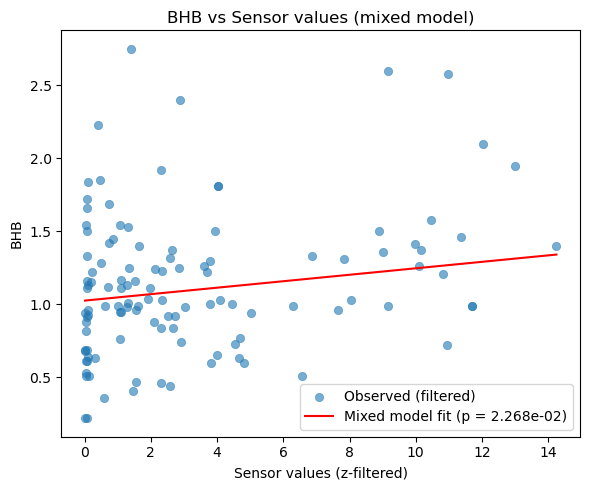

/usr/lib/python3/dist-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


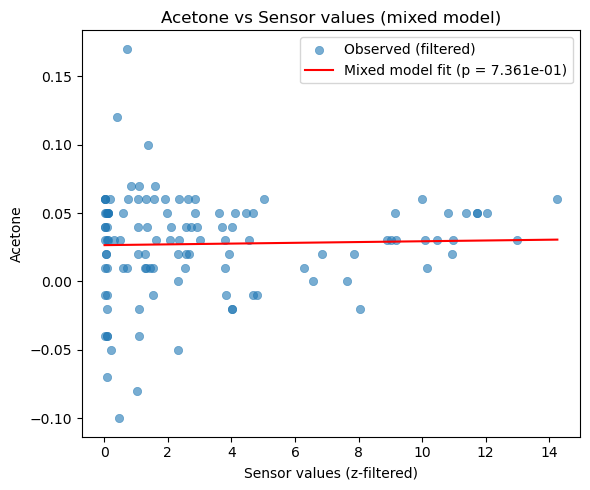

/usr/lib/python3/dist-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


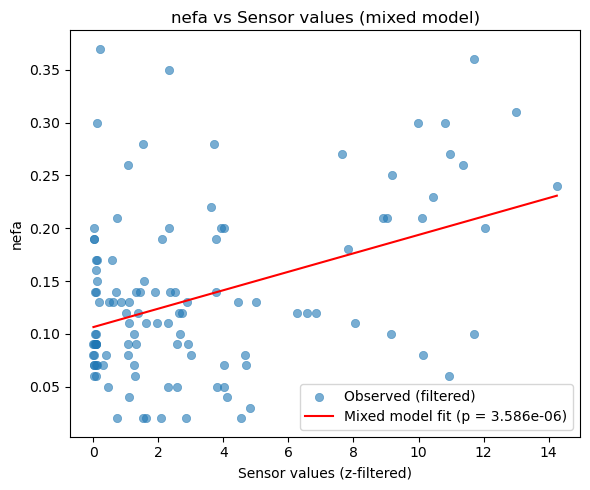

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy.stats import zscore

def plot_mixed_model(df, response, predictor="sensor_values", group="cowid", z_thresh=3):
    """
    Fit mixed model with random intercept, filter predictor by z-score,
    and plot observed vs fitted line from model fixed effects.
    """
    # Z-score filter
    df = df.copy()
    df["sensor_z"] = zscore(df[predictor], nan_policy="omit")
    filtered_df = df[df["sensor_z"].abs() <= z_thresh].copy()
    
    # Fit mixed model
    model = smf.mixedlm(f"Q('{response}') ~ {predictor}",
                        filtered_df,
                        groups=filtered_df[group])
    result = model.fit()
    
    # Extract p-value
    pval = result.pvalues[predictor]
    
    # Generate prediction grid
    sensor_grid = np.linspace(filtered_df[predictor].min(),
                              filtered_df[predictor].max(), 100)
    pred_fixed = result.predict(exog=dict(sensor_values=sensor_grid))
    
    # --- Plot ---
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=predictor, y=response, data=filtered_df,
                    alpha=0.6, edgecolor=None, label="Observed (filtered)")
    
    plt.plot(sensor_grid, pred_fixed, color="red",
             label=f"Mixed model fit (p = {pval:.3e})")
    
    plt.xlabel("Sensor values (z-filtered)")
    plt.ylabel(response)
    plt.title(f"{response} vs Sensor values (mixed model)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return result

# --- Example usage ---
result_bhb = plot_mixed_model(merged_milk_df, "BHB")
result_acetone = plot_mixed_model(merged_milk_df, "Acetone")
result_nefa = plot_mixed_model(merged_milk_df, "nefa")


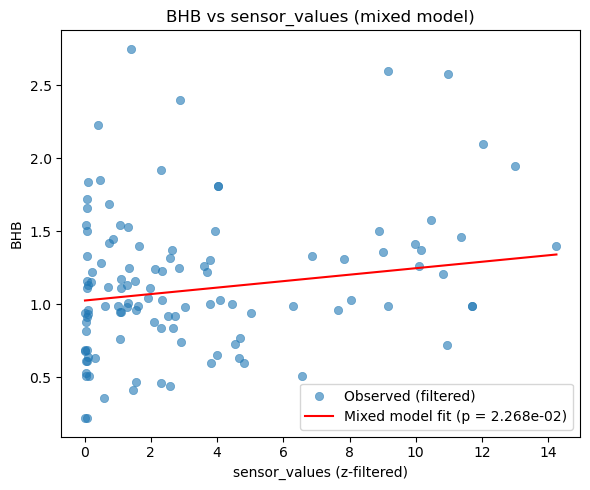

/usr/lib/python3/dist-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


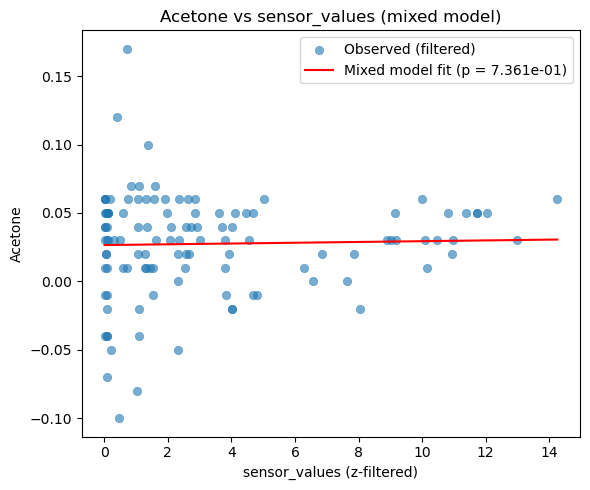

/usr/lib/python3/dist-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


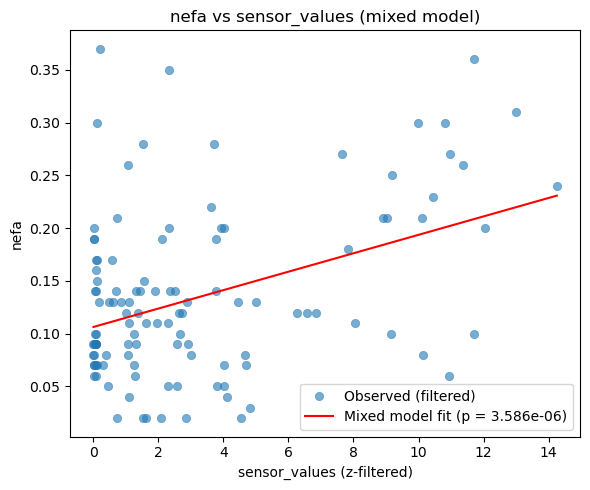

Pseudo R² for BHB: 0.760
Pseudo R² for Acetone: 0.661
Pseudo R² for NEFA: 0.277


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy.stats import zscore

def plot_mixed_model_with_r2(df, response, predictor="sensor_values", group="cowid", z_thresh=3):
    """
    Fit mixed model with random intercept, filter predictor by z-score,
    plot observed vs fitted line from model fixed effects, and return pseudo R².
    
    Returns:
        result: fitted mixed model
        r2: pseudo R² (correlation^2 between observed and fitted)
    """
    # Z-score filter
    df = df.copy()
    df["sensor_z"] = zscore(df[predictor], nan_policy="omit")
    filtered_df = df[df["sensor_z"].abs() <= z_thresh].copy()
    
    # Fit mixed model
    model = smf.mixedlm(f"Q('{response}') ~ {predictor}",
                        filtered_df,
                        groups=filtered_df[group])
    result = model.fit()
    
    # Extract p-value
    pval = result.pvalues[predictor]
    
    # Generate prediction grid (fixed effect only)
    sensor_grid = np.linspace(filtered_df[predictor].min(),
                              filtered_df[predictor].max(), 100)
    pred_fixed = result.predict(exog=dict(sensor_values=sensor_grid))
    
    # Calculate pseudo R² using correlation of observed vs fitted
    r2 = np.corrcoef(filtered_df[response], result.fittedvalues)[0,1]**2
    
    # --- Plot ---
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=predictor, y=response, data=filtered_df,
                    alpha=0.6, edgecolor=None, label="Observed (filtered)")
    plt.plot(sensor_grid, pred_fixed, color="red",
             label=f"Mixed model fit (p = {pval:.3e})")
    plt.xlabel(f"{predictor} (z-filtered)")
    plt.ylabel(response)
    plt.title(f"{response} vs {predictor} (mixed model)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return result, r2

# --- Example usage ---
result_bhb, r2_bhb = plot_mixed_model_with_r2(merged_milk_df, "BHB")
result_acetone, r2_acetone = plot_mixed_model_with_r2(merged_milk_df, "Acetone")
result_nefa, r2_nefa = plot_mixed_model_with_r2(merged_milk_df, "nefa")

print(f"Pseudo R² for BHB: {r2_bhb:.3f}")
print(f"Pseudo R² for Acetone: {r2_acetone:.3f}")
print(f"Pseudo R² for NEFA: {r2_nefa:.3f}")


In [46]:
merged_milk_df['sensor_values_square']= merged_milk_df['sensor_values']**2

In [47]:
merged_milk_df[['sensor_values_square', 'sensor_values']]

,sensor_values_square,sensor_values
0,1.7689,1.33
1,2.6569,1.63
2,0.5476,0.74
3,0.5041,0.71
4,0.2025,0.45
...,...,...
110,84.0889,9.17
111,102.0100,10.10
112,137.1241,11.71
113,116.8561,10.81


In [48]:
merged_milk_df.COWID_x.nunique()

57

In [49]:
merged_milk_df.columns

Index(['cowid', 'sensor_values', 'blood', 'date', 'sensor values', 'cohort',
       'day', 'DATE_x', 'COHORT_x', 'PEN_x', 'TREATMENT_x', 'COWID_x', 'DAY_x',
       'DIM', 'LACT', 'TBIL (mg/dL)', 'NEFA (meEq/L)', 'HBUT (mg/dL)',
       'GLUC (mg/dL)', 'GGT (U/L)', 'CHOL (mg/dL)', 'AST (U/L)', 'ALT (U/L)',
       'ALP (U/L)', 'ALB (TL=<0.5) *(g/dL)', 'DATE_y', 'COHORT_y', 'PEN_y',
       'TREATMENT_y', 'COWID_y', 'DAY_y', 'Fat', 'Protein', 'Lactose', 'SNF',
       'MUN', 'SCC', 'BHB', 'Acetone', 'Unnamed: 14', 'Unnamed: 15', 'sick ',
       'Check', 'no data ', 'sensor_values_scaled', 'BHB_scaled',
       'Acetone_scaled', 'hbut', 'Breath Acetone (ppm)', 'Serum BHB (mmol/L)',
       'Milk Acetone (mM/L)', 'Milk BHB (mM/L)', 'Serum NEFA (meEq/L)',
       'Serum GLUC (mg/dL)', 'fitted', 'resid', 'fitted_acetone',
       'resid_acetone', 'nefa', 'fitted_nefa', 'resid_nefa', 'sensor_z',
       'sensor_values_square'],
      dtype='object')

In [51]:
merged_milk_df['LACT'].value_counts

<bound method IndexOpsMixin.value_counts of 0      1
1      3
2      1
3      1
4      7
      ..
110    1
111    1
112    1
113    1
114    1
Name: LACT, Length: 115, dtype: object>

In [30]:

merged_milk_df['lactation']= merged_milk_df['LACT'].astype(str).apply(lambda x: 'primiparous' if x=='1' else 'multiparous')



In [31]:
merged_milk_df.groupby('lactation')['cowid'].nunique()

lactation
multiparous    25
primiparous    32
Name: cowid, dtype: int64

In [42]:
merged_milk_df['dim_2']= merged_milk_df['DIM'].astype(int).apply(lambda x: 'early' if x<=120 else ('mid' if 120<x<240 else 'late'))  

In [43]:
merged_milk_df.groupby('dim_2')['cowid'].nunique()

dim_2
early    32
mid      25
Name: cowid, dtype: int64

In [1]:
import pandas as pd 
import numpy as np 


In [5]:
file= pd.read_csv("C:\\Users\\rajes\\Downloads\\data (1)\\Cows -.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\rajes\\Downloads\\data (1)\\Cows -.csv'

In [6]:
file= pd.read_csv('/mnt/c/users/rajes/Downloads/data (1)/Cows -.csv')

In [15]:
file['event']= file['Hlth_StatEvnt'].str.split().str[1]

In [17]:
file['event'].unique()

array(['73', '30', 'S', 'P', '81', '50', 'C', '22', 'K', '24', 'H', 'B',
       'N', 'T', 'D', '42', '90', '43', '44', '71', '60', '40', '35', 'R',
       'V', '57', '20', '21', '70', '38', '39', '23', '36', 'A', '25',
       '37', '41', '-38764', '-38777', '-38781', '-38800', '-38801', '45',
       '-38632', '-38640', '-38653', '-38625', '-38603', '-38634',
       '-38674'], dtype=object)